## Imports and Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import acf, plot_acf, pacf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import het_arch
import warnings
warnings.filterwarnings("ignore")

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

import holidays
import datetime

In [2]:
by_days = pd.read_pickle('sales_by_day.pkl')
by_days.head()

order_date
2015-01-01    2713.85
2015-01-02    2731.90
2015-01-03    2662.40
2015-01-04    1755.45
2015-01-05    2065.95
Name: total_price, dtype: float64

# ARIMA Modeling

Having taken a look at our data with rolling averages and standard deviations, the seasonal decomposition plots, the acf and pacf plots, and adfuller test results, we're fairly certain our data is stationary. The decomposition plots, the rolling average plots, and the adfuller test tell us that our data has no trend. The seasonal decomposition and basic time series plots tell us that our data has a high degree of seasonality. The acf and pacf plots tell us that this seasonality comes in 7 day windows. This exploratory data analysis is useful, but by no means deterministic with regards to the correct model order choices. The parameter space is constrained, but not fully determined. Therefore, we will still attempt a grid search for some model orders, while certain others are known. For example, the fact that our daily sales data had no trend means that we did not need to take a difference to achieve stationarity. Therefore, the d parameter of the Autoregressive portion of the ARIMA model will be zero (p, d, q).

In [20]:
# Designate train/test split. Since this is a time series, order matters. Therefore when making our split, we must preserve the order of data points. 
# To do this we simply take the first nine months for our training data and reserve the remaining three months for testing data.
train = by_days.loc[:'2015-08-31']
test = by_days.loc['2015-09-01':]

In [21]:
train.head()

order_date
2015-01-01    2713.85
2015-01-02    2731.90
2015-01-03    2662.40
2015-01-04    1755.45
2015-01-05    2065.95
Name: total_price, dtype: float64

# GRIDSEARCH TIME NEEDS WORK

In [22]:
# Custom wrapper for ARIMA model to use with scikit-learn's GridSearchCV
class ARIMAWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1, 0, 1), seasonal_order=(0, 0, 0, 0)):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model = None

    def fit(self, X, y):
        self.model = ARIMA(endog=y, order=self.order, seasonal_order=self.seasonal_order)
        self.model_fit = self.model.fit()
        return self

    def predict(self, X):
        return self.model_fit.forecast(steps=len(X))

In [23]:
# Create a smaller parameter grid
param_grid = {
    'order': [(p, d, q) for p in range(1, 84, 7) for d in range (0, 2) for q in range(1, 3)],
    'seasonal_order': [(P, D, Q, S) for P in range(1, 3) for D in range(0, 3) for Q in range(1, 3) for S in range(0, 8)]
}

# Initialize the GridSearchCV
grid = GridSearchCV(estimator=ARIMAWrapper(), param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)

# Fit to the data
grid.fit(train.index, train)

# Summary of the best model
print(f'Best ARIMA{grid.best_params_["order"]}x{grid.best_params_["seasonal_order"]} model - MSE:{-grid.best_score_}')

# Predicting and calculating MSE
y_pred = grid.best_estimator_.predict(test)
mae = mean_absolute_error(test, y_pred)
rmse = sqrt(mean_squared_error(test, y_pred))

print(f'Mean Absolute Error (MSE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Fitting 3 folds for each of 4608 candidates, totalling 13824 fits


Best ARIMA(1, 0, 2)x(1, 0, 2, 7) model - MSE:109931.06481033076
Mean Absolute Error (MSE): 273.1777686062062
Root Mean Squared Error (RMSE): 433.22175424990473


In [24]:
# Create and fit the ARIMA model
# A first pass, using all 1's for model orders except for seasonality (7)
model = ARIMA(endog=train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7), freq = 'D')
results = model.fit()

In [25]:
# # Model summary
# print(results.summary())

In [26]:
# # Model diagnostics
# results.plot_diagnostics()

In [27]:
# Create and store predictions for the beginning of the range of dates contained in the test set (September 1st through December 31st)
predictions = results.predict(start = test.index[0], end = test.index[-1])
predictions.sample(5)

2015-10-19    2204.917925
2015-12-05    2363.639912
2015-09-01    2154.101484
2015-10-12    2206.175054
2015-09-16    2217.202824
Name: predicted_mean, dtype: float64

In [28]:
# # Visually inspect the ARIMA model's predictions against the holdout set
# first_forecast = pd.concat([test, predictions], axis = 1) # Assemble test set and forecast into one dataframe
# first_forecast.rename(columns = {'total_price': 'recorded_sales', 'predicted_mean': 'forecast'}, inplace = True) # rename columns to be more intuitive
# first_forecast.plot()
# plt.title('ARIMA Model Sales Forecast vs. Recorded Sales')
# plt.xlabel('Time (Day)')
# plt.ylabel('Sales ($)')
# plt.show()

In [29]:
# Obtain and inspect two error metrics: Root Mean Squared Error and Mean Absolute Error
rmse = np.sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)

scoring_dict = {}
scoring_dict = {'model 1': [model.order +  model.seasonal_order, rmse.round(2), mae.round(2)]}
scoring_dict

{'model 1': [(1, 1, 1, 1, 1, 1, 7), 435.51, 267.49]}

### Begin Fiddling with ARIMA model orders

Start with changing differencing order to 0

In [30]:
# Create and fit the ARIMA model
# A second pass, using all 1's for model orders except for seasonality (7) and a differencing of 0 (d = 0). This was divined through adfuller test above.
model2 = ARIMA(endog=train, order=(1, 0, 1), seasonal_order=(1, 1, 1, 7), freq = 'D')
results2 = model2.fit()

In [31]:
# # Model summary
# print(results2.summary())

In [32]:
# # Model diagnostics
# results2.plot_diagnostics()

In [33]:
# Create and store predictions for the beginning of the range of dates contained in the test set (September 1st through December 31st)
predictions2 = results2.predict(start = test.index[0], end = test.index[-1])
predictions2.sample(5)

2015-10-11    1886.789798
2015-11-09    2230.632686
2015-09-03    2245.095168
2015-10-18    1886.269520
2015-11-01    1886.269798
Name: predicted_mean, dtype: float64

In [34]:
# # Visually inspect the ARIMA model's predictions against the holdout set
# first_forecast = pd.concat([test, predictions2], axis = 1) # Assemble test set and forecast into one dataframe
# first_forecast.rename(columns = {'total_price': 'recorded_sales', 'predicted_mean': 'forecast'}, inplace = True) # rename columns to be more intuitive
# first_forecast.plot()
# plt.title('ARIMA Model Sales Forecast vs. Recorded Sales')
# plt.xlabel('Time (Day)')
# plt.ylabel('Sales ($)')
# plt.show()

In [35]:
# Obtain and inspect two error metrics: Root Mean Squared Error and Mean Absolute Error
rmse = np.sqrt(mean_squared_error(test, predictions2))
mae = mean_absolute_error(test, predictions2)
print('Out of the box ARIMA model error metrics ($):')
print('Root mean squared error:', rmse.round(2), 'Mean absolute error', mae.round(2))

scoring_dict['model 2'] =  [model2.order +  model2.seasonal_order, rmse.round(2), mae.round(2)]
scoring_dict

Out of the box ARIMA model error metrics ($):
Root mean squared error: 434.27 Mean absolute error 269.27


{'model 1': [(1, 1, 1, 1, 1, 1, 7), 435.51, 267.49],
 'model 2': [(1, 0, 1, 1, 1, 1, 7), 434.27, 269.27]}

Now try fiddling with p

In [36]:
# Create and fit the ARIMA model
model3 = ARIMA(endog=train, order=(1, 0, 1), seasonal_order=(2, 1, 1, 7), freq = 'D')
results3 = model3.fit()

In [37]:
# # Model summary
# print(results3.summary())

In [38]:
# # Model diagnostics
# results3.plot_diagnostics()

In [39]:
# Create and store predictions for the beginning of the range of dates contained in the test set (September 1st through December 31st)
predictions2 = results2.predict(start = test.index[0], end = test.index[-1])
predictions2.sample(5)

2015-09-28    2230.631791
2015-09-18    2720.041031
2015-11-02    2231.152092
2015-10-17    2392.662260
2015-09-15    2179.833131
Name: predicted_mean, dtype: float64

In [40]:
# # Visually inspect the ARIMA model's predictions against the holdout set
# first_forecast = pd.concat([test, predictions2], axis = 1) # Assemble test set and forecast into one dataframe
# first_forecast.rename(columns = {'total_price': 'recorded_sales', 'predicted_mean': 'forecast'}, inplace = True) # rename columns to be more intuitive
# first_forecast.plot()
# plt.title('ARIMA Model Sales Forecast vs. Recorded Sales')
# plt.xlabel('Time (Day)')
# plt.ylabel('Sales ($)')
# plt.show()

In [41]:
# Obtain and inspect two error metrics: Root Mean Squared Error and Mean Absolute Error
rmse = np.sqrt(mean_squared_error(test, predictions2))
mae = mean_absolute_error(test, predictions2)
print('Out of the box ARIMA model error metrics ($):')
print('Root mean squared error:', rmse.round(2), 'Mean absolute error', mae.round(2))

scoring_dict['model 2'] =  [model2.order +  model2.seasonal_order, rmse.round(2), mae.round(2)]
scoring_dict

Out of the box ARIMA model error metrics ($):
Root mean squared error: 434.27 Mean absolute error 269.27


{'model 1': [(1, 1, 1, 1, 1, 1, 7), 435.51, 267.49],
 'model 2': [(1, 0, 1, 1, 1, 1, 7), 434.27, 269.27]}

### Baseline Comparison
Your model's performance means only so much on its own. Often we find ourselves needing to know how well our model has done *compared to* the current model, or compared to some baseline. Here we explore different baselines and see what their error metrics are like.

In [42]:
# Generating Seasonal Naive Forecast
seasonal_naive_forecast = test.shift(7)

# Remove NaN values produced by the shift operation
seasonal_naive_forecast.dropna(inplace=True)

In [43]:
rmse = np.sqrt(mean_squared_error(test[7:], seasonal_naive_forecast))
mae = mean_absolute_error(test[7:], seasonal_naive_forecast)
rmse, mae

(580.5303153526767, 370.5682608695652)

In [44]:
noise = np.random.uniform(-455, 455, size = len(seasonal_naive_forecast))
noisy_seasonal_naive_forecast = seasonal_naive_forecast + noise

rmse = np.sqrt(mean_squared_error(test[7:], noisy_seasonal_naive_forecast))
mae = mean_absolute_error(test[7:], noisy_seasonal_naive_forecast)
rmse, mae

(635.8175111460748, 448.45443242533565)

In [45]:
# Calculate residuals
residuals = test[7:] - seasonal_naive_forecast

# Determine their standard deviation
natural_variability = residuals.std()

In [46]:
natural_variability

582.2469550285081

In [47]:
noise = np.random.uniform(-natural_variability, natural_variability, size = len(seasonal_naive_forecast))
noisy_seasonal_naive_forecast = seasonal_naive_forecast + noise

rmse = np.sqrt(mean_squared_error(test[7:], noisy_seasonal_naive_forecast))
mae = mean_absolute_error(test[7:], noisy_seasonal_naive_forecast)
rmse, mae

(676.5639957835285, 497.61138316065774)

In [48]:
(568.8026191083292, 367.2661815068493)

(568.8026191083292, 367.2661815068493)

In [49]:
noise_dates = []
us_holidays = holidays.UnitedStates(years=2015)
for date, name in sorted(us_holidays.items()):
    print(f"{date}: {name}")
    noise_dates.append(date)

2015-01-01: New Year's Day
2015-01-19: Martin Luther King Jr. Day
2015-02-16: Washington's Birthday
2015-05-25: Memorial Day
2015-07-03: Independence Day (Observed)
2015-07-04: Independence Day
2015-09-07: Labor Day
2015-10-12: Columbus Day
2015-11-11: Veterans Day
2015-11-26: Thanksgiving
2015-12-25: Christmas Day


In [50]:
dummy_model = seasonal_naive_forecast.copy()

In [51]:
def boost_sales_on_holidays(data, holiday_list, coefficient):
    # Filter holidays from September onward
    holiday_list = [date for date in holiday_list if date >= datetime.date(2015, 9, 1)]
    
    # Convert the list to a Pandas datetime format for easier comparison
    holiday_list = pd.to_datetime(holiday_list)
    
    # Boost the 'sales' column by 50% where the date matches a holiday
    data.loc[data.index.isin(holiday_list)] *= 1.5

In [52]:
# Apply the boost to the DataFrame
boost_sales_on_holidays(dummy_model, noise_dates, 1.5)

In [53]:
dummy_model, seasonal_naive_forecast

(order_date
 2015-09-08    2352.85
 2015-09-09    1865.55
 2015-09-10    2252.60
 2015-09-11    2960.95
 2015-09-12    2537.80
                ...   
 2015-12-27    2104.90
 2015-12-28    2100.70
 2015-12-29    1882.95
 2015-12-30    2244.30
 2015-12-31    2137.85
 Name: total_price, Length: 115, dtype: float64,
 order_date
 2015-09-08    2352.85
 2015-09-09    1865.55
 2015-09-10    2252.60
 2015-09-11    2960.95
 2015-09-12    2537.80
                ...   
 2015-12-27    2104.90
 2015-12-28    2100.70
 2015-12-29    1882.95
 2015-12-30    2244.30
 2015-12-31    2137.85
 Name: total_price, Length: 115, dtype: float64)

<Axes: xlabel='order_date'>

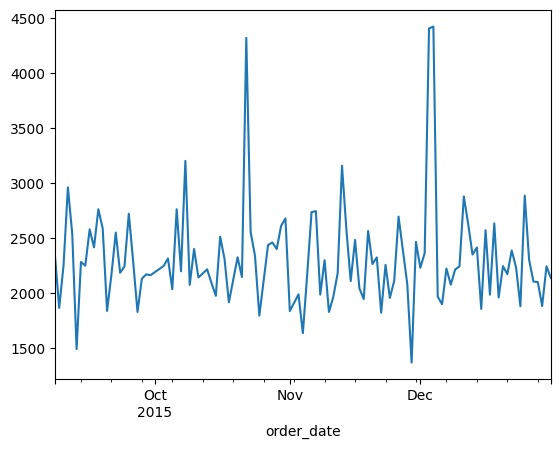

In [54]:
seasonal_naive_forecast.plot()

<Axes: xlabel='order_date'>

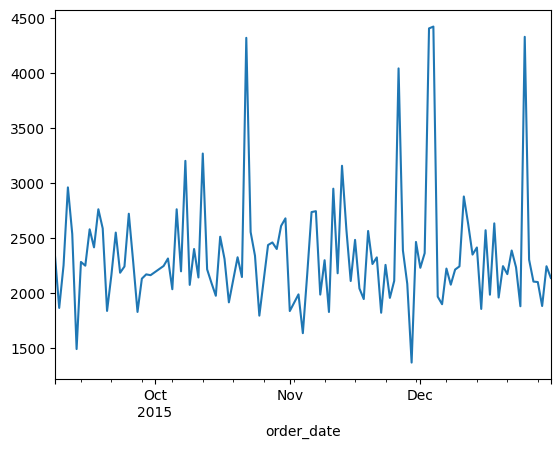

In [55]:
dummy_model.plot()

<Axes: xlabel='order_date'>

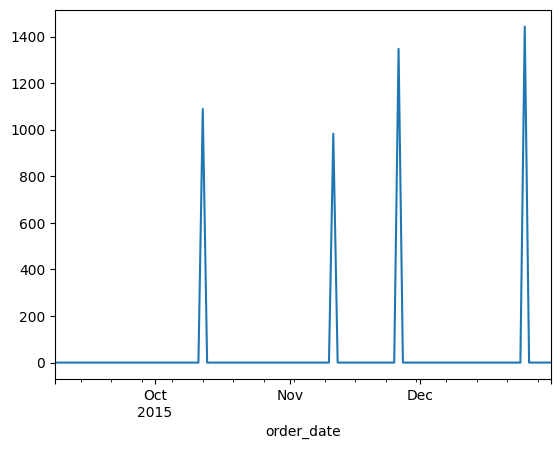

In [56]:
difference = dummy_model - seasonal_naive_forecast
difference.plot()

In [57]:
rmse = np.sqrt(mean_squared_error(test[7:], dummy_model))
mae = mean_absolute_error(test[7:], dummy_model)
rmse, mae

(613.1687445913645, 389.42293478260865)

### Exploring Hourly Sales as Timeseries

In [58]:
# Join date and time columns for combined datetime column
df['complete_order_date'] = pd.to_datetime(df['order_date'].astype(str)+' '+df['order_time'].astype(str))

NameError: name 'df' is not defined

In [ ]:
# Create hourly downsampled sales from complete datetime column
hourly_sales = df[['complete_order_date', 'total_price']]
hourly_sales.set_index('complete_order_date', inplace = True)
hourly_sales = hourly_sales.resample('1H').sum()

In [ ]:
hourly_sales

,total_price
complete_order_date,
2015-01-01 11:00:00,105.25
2015-01-01 12:00:00,263.25
2015-01-01 13:00:00,577.20
2015-01-01 14:00:00,246.00
2015-01-01 15:00:00,230.25
...,...
2015-12-31 19:00:00,396.15
2015-12-31 20:00:00,278.50
2015-12-31 21:00:00,113.20


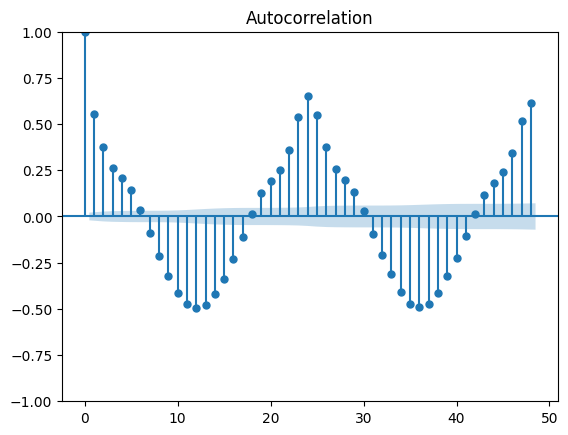

In [ ]:
# Autocorrelation for data downsampled to daily
plot_acf(hourly_sales, lags = 48)
plt.show()

In [ ]:
# # Apply seasonal decomposition
# result = seasonal_decompose(by_days, model='additive') # Use 'multiplicative' for multiplicative model

# # # You can then access the individual components
# # trend = result.trend
# # seasonal = result.seasonal
# # residual = result.resid

# fig = plt.figure()  
# fig = result.plot()  
# fig.set_size_inches(15, 8)
# plt.show()